In [1]:
# !pip install mofapy2 
# !pip install mofax

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from mofapy2.run.entry_point import entry_point
import mofax as mfx
from typing import Dict, List, Tuple, Optional
import warnings

## Phase 2 — Model training

1. Data preparation
    - Load proteomics, lipidomics, metabolomics.
    - Separate the label row, convert measurements to numeric, set sample IDs as index.
    - Ensure shapes and dtypes are correct before training.

2. MOFA+ training
    - 2.1 MOFA+ runs
      - Run 1 — Full data + only ARD  
         - Purpose: train on all features with ARD regularization.  
         - Outputs: saved model `mofa/run_01_only_ARD.hdf5`, R² per view.
      - Run 2 — Filtered proteins (top variance)  
         - Purpose: reduce proteomics features (e.g., top 2000 by variance) to improve signal / speed.  
         - Outputs: saved model `mofa/run_02_filtered_proteins.hdf5`, R² per view.
    - 2.2 Comparison & visualization  
      - Load both saved models, compute R² per view, plot stacked variance-per-factor barplots and weight heatmaps to compare view contributions and factor structure.

3. DIABLO training (optional)
    - Next: prepare inputs (matched samples across views), tune regularization and components, run cross-validated DIABLO and inspect variable loadings and classification performance.

### Step 1. Data Prep

In [5]:
# Load datasets
proteins = pd.read_csv('data/proteins.csv')
lipids = pd.read_csv('data/lipids.csv')
metabolites = pd.read_csv('data/metabolites.csv')

# Split labels and keep it separately
pro_labels = proteins[proteins['sample'] == 'label'].iloc[0,1:].values
lipid_labels = lipids[lipids['sample'] == 'label'].iloc[0,1:].values
meta_labels = metabolites[metabolites['sample'] == 'label'].iloc[0,1:].values

# Now remove the label row
pro_nolabel = proteins[proteins['sample'] != 'label'].reset_index(drop=True)
lipid_nolabel = lipids[lipids['sample'] != 'label'].reset_index(drop=True)
meta_nolabel = metabolites[metabolites['sample'] != 'label'].reset_index(drop=True)

# Set id_cols as index
pro_nolabel = pro_nolabel.set_index('sample')
lipid_nolabel = lipid_nolabel.set_index('sample')
meta_nolabel = meta_nolabel.set_index('sample')

### Step 2. MOFA+ Training

In [7]:
# ==================== Helper tools ====================
class MOFATrainer:
    """
    One fixed MOFA+ trainer supporting configuration
    """
    def __init__(
        self,
        pro: pd.DataFrame,
        lipid: pd.DataFrame,
        meta: pd.DataFrame,
        labels : np.ndarray,
        views_names = ['proteomics', 'lipidomics', 'metabolomics'],
    ):
        """
        Parameters:
        -----------
        pro : pd.DataFrame
            Proteomics data (samples x features)
        lipid : pd.DataFrame
            Lipidomics data (samples x features)
        meta : pd.DataFrame
            Metabolomics data (samples x features)
        labels : np.ndarray
            Sample class labels (for later analysis, NOT used in MOFA+ training)
        views_names : List[str]
            Names of views 
        """
        # Transpose: features × samples → samples × features
        self.pro = pro.T 
        self.lipid = lipid.T
        self.meta = meta.T
        self.views_names = views_names
        self.pro_labels = pro_labels

        # Store labels separately (NOT used in MOFA+ training)
        self.labels = labels

        # Extract metadata
        pro_features = [f for f in self.pro.columns.tolist()]
        lipid_features = [f for f in self.lipid.columns.tolist()]
        meta_features = [f for f in self.meta.columns.tolist()]

        self.sample_names = self.pro.index.tolist()
        self.group_names = self.pro_labels.tolist()
        self.features_names = [
            pro_features,
            lipid_features,
            meta_features
        ]

        print(f"Initialized trainer:")
        print(f"  Samples: {len(self.sample_names)}")
        print(f"  Proteomics features: {len(pro_features)}")
        print(f"  Lipidomics features: {len(lipid_features)}")
        print(f"  Metabolomics features: {len(meta_features)}")
        if labels is not None:
            print(f"  Labels: {np.unique(labels, return_counts=True)}")
        
    def fit(
        self,
        factors: int = 10,
        seed: int = 2026,
        iterations: int = 1000,
        convergence_mode: str = 'medium',
        dropR2: float = 0.001,
        save_path: Optional[str] = None,
        verbose: bool = False
    ) -> entry_point:
        """
        Train MOFA+ model
        
        Parameters:
        -----------
        factors : int
            Number of latent factors
        seed : int
            Random seed for reproducibility
        iterations : int
            Maximum training iterations
        convergence_mode : str
            'slow', 'medium', or 'fast'
        dropR2: float
            Minimum variance explained criteria to choose relevant factors
        save_path : str or None
            Path to save model (if None, doesn't save)
        verbose : bool
            Print training progress
            
        Returns:
        --------
        ent : entry_point
            Trained MOFA+ model
        """
        # Prepare nested data structure
        data_nested = [
            [self.pro.values],
            [self.lipid.values],
            [self.meta.values]
        ]
        
        # Initialize MOFA+
        ent = entry_point()
                
        # Data options
        ent.set_data_options(
            scale_views=True,   # Scale each view
            scale_groups=False
        )
        
        # Set data
        ent.set_data_matrix(
            data=data_nested,
            views_names=self.views_names,
            groups_names=['group1'],
            samples_names=[self.sample_names],
            features_names=self.features_names
        )
        
        # Configure model
        ent.set_model_options(
            factors=factors,
            spikeslab_weights=True,  # Feature-level sparsity
            ard_factors=True,        # Factor-level sparsity
            ard_weights=True         # View-specific regularization (helps with imbalance)
        )
        
        ent.set_train_options(
            iter=iterations,
            convergence_mode=convergence_mode,
            dropR2=dropR2,
            seed=seed,
            verbose=verbose
        )
        
        # Build and train
        if verbose:
            print("Building model...")
        ent.build()
        
        if verbose:
            print("Training model...")
        ent.run()
        
        # Save if requested
        if save_path is not None:
            ent.save(save_path)
            if verbose:
                print(f"Model saved to {save_path}")
        
        return ent

In [8]:
# MOFA+ Run 1 (Full data + only ARD)

# Train MOFA+ models 
train1 = MOFATrainer(
    pro_nolabel,
    lipid_nolabel,
    meta_nolabel,
    labels=pro_labels,
    views_names=['proteomics', 'lipidomics', 'metabolomics'],
)

model1 = train1.fit(
        factors=10,
        seed=2026,
        iterations=1000,
        convergence_mode='medium',
        dropR2=0.001,
        save_path='mofa_results/run_01_only_ARD.hdf5',
        verbose=False
)

Initialized trainer:
  Samples: 10
  Proteomics features: 7537
  Lipidomics features: 1029
  Metabolomics features: 200
  Labels: (array(['Macula', 'Periphery'], dtype=object), array([5, 5]))

        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Scaling views to unit variance...

Successfully loaded view='proteomics' group='group1' with N=10 samples and D=7537 features...
Successfully loaded view='lipidomics' group='group1' with N=

In [9]:
# MOFA+ Run 2 (Filtered proteins + ARD)

# Filter proteins
pro_nolabel = pro_nolabel.apply(pd.to_numeric, errors='coerce') # Force all values to be numeric in case they are still strings
pro_var = pro_nolabel.var(axis=1)
top_proteins = (pro_var.nlargest(min(2000, len(pro_var))).index)
pro_nolabel_filtered = pro_nolabel.loc[top_proteins]

# Train model
train2 = MOFATrainer(
    pro_nolabel_filtered,
    lipid_nolabel,
    meta_nolabel,
    labels=pro_labels,
    views_names=['proteomics', 'lipidomics', 'metabolomics'],
)

model2 = train2.fit(
        factors=10,
        seed=2026,
        iterations=1000,
        convergence_mode='medium',
        dropR2=0.001,
        save_path='mofa_results/run_02_filtered_proteins.hdf5',
        verbose=False
)

Initialized trainer:
  Samples: 10
  Proteomics features: 2000
  Lipidomics features: 1029
  Metabolomics features: 200
  Labels: (array(['Macula', 'Periphery'], dtype=object), array([5, 5]))

        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Scaling views to unit variance...

Successfully loaded view='proteomics' group='group1' with N=10 samples and D=2000 features...
Successfully loaded view='lipidomics' group='group1' with N=

In [10]:
# Comparison
"""
Adapted from 
https://github.com/bioFAM/mofax/blob/master/notebooks/getting_started_pbmc10k.ipynb
"""

# Load MOFA+ outputs for 2 runs
m1 = mfx.mofa_model("mofa_results/run_01_only_ARD.hdf5")
m2 = mfx.mofa_model("mofa_results/run_02_filtered_proteins.hdf5")

# Basic model check 
n_features1 = m1.get_factors(df=True).shape[1]
n_features2 = m2.get_factors(df=True).shape[1]

print('='*15 + 'Model 1 – Full Data: Basic Model Check' + '='*37)
print(f"""\
Samples: {m1.shape[0]}
Features: {m1.shape[1]}
Groups of cells: {', '.join(m1.groups)}
Views: {', '.join(m1.views)}
Number of Latent Factors Found: {n_features1}
""")

print('='*15 + 'Model 2 – Filtered Proteins (2000): Basic Model Check' + '='*15)
print(f"""\
Samples: {m2.shape[0]}
Features: {m2.shape[1]}
Groups of cells: {', '.join(m2.groups)}
Views: {', '.join(m2.views)}
Number of Latent Factors Found: {n_features2}
""")

===============Model 1 – Full Data: Basic Model Check=====================================
Samples: 10
Features: 8766
Groups of cells: group1
Views: proteomics, lipidomics, metabolomics
Number of Latent Factors Found: 7

===============Model 2 – Filtered Proteins (2000): Basic Model Check===============
Samples: 10
Features: 3229
Groups of cells: group1
Views: proteomics, lipidomics, metabolomics
Number of Latent Factors Found: 7



In [11]:
# Total Variance Explained  
def r2_per_view(model, model_name):
    return (
        model.get_r2()
             .groupby("View")["R2"]
             .sum()
             .rename(model_name)
    )

r2_table = pd.concat(
    [r2_per_view(m1, "Model 1"),
    r2_per_view(m2, "Model 2"),
    ], axis=1
)

print(r2_table)

                Model 1    Model 2
View                              
lipidomics    68.389431  72.765711
metabolomics  20.369884  23.733495
proteomics    52.989725  76.115912


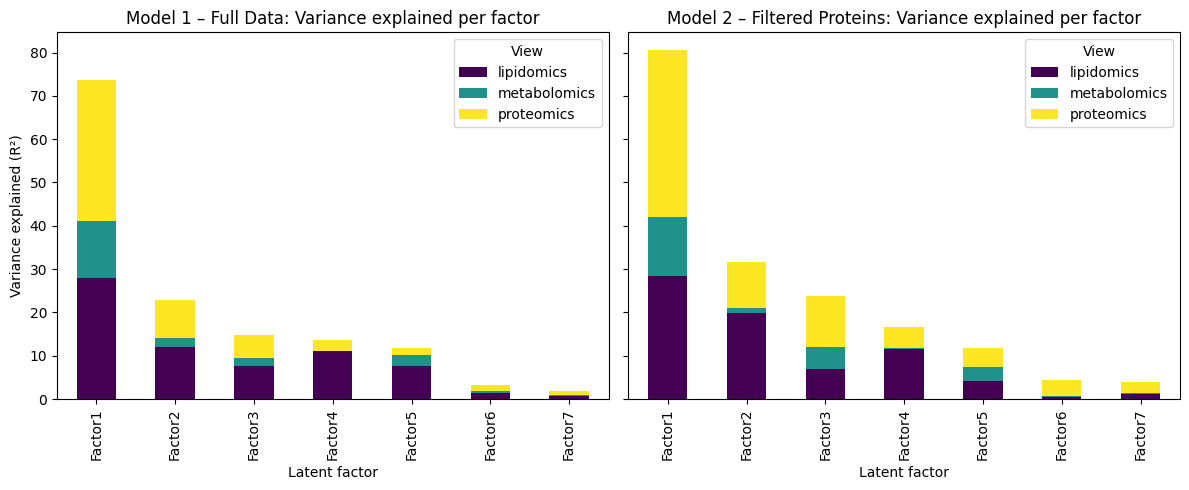

In [16]:
# Plots
output_dir = Path('plots/downstream_analysis')
output_dir.mkdir(parents=True, exist_ok=True)

var_sum1 = m1.get_r2(factors=list(range(n_features1)))
var_sum2 = m2.get_r2(factors=list(range(n_features2)))

fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

df1 = (var_sum1.pivot(index="Factor", columns="View", values="R2").fillna(0))
df1.plot(
    kind="bar",
    stacked=True,
    width=0.5,
    ax=axs[0],
    colormap="viridis"
)

axs[0].set_ylabel("Variance explained (R²)")
axs[0].set_xlabel("Latent factor")
axs[0].set_title("Model 1 – Full Data: Variance explained per factor")
axs[0].legend(title="View")

df2 = (var_sum2.pivot(index="Factor", columns="View", values="R2").fillna(0))
df2.plot(
    kind="bar",
    stacked=True,
    width=0.5,
    ax=axs[1],
    colormap="viridis"
)

axs[1].set_ylabel("Variance explained (R²)")
axs[1].set_xlabel("Latent factor")
axs[1].set_title("Model 2 – Filtered Proteins: Variance explained per factor")
axs[1].legend(title="View")

plt.tight_layout()
plt.savefig(output_dir / 'variance_explained_comparison.png')
plt.show()

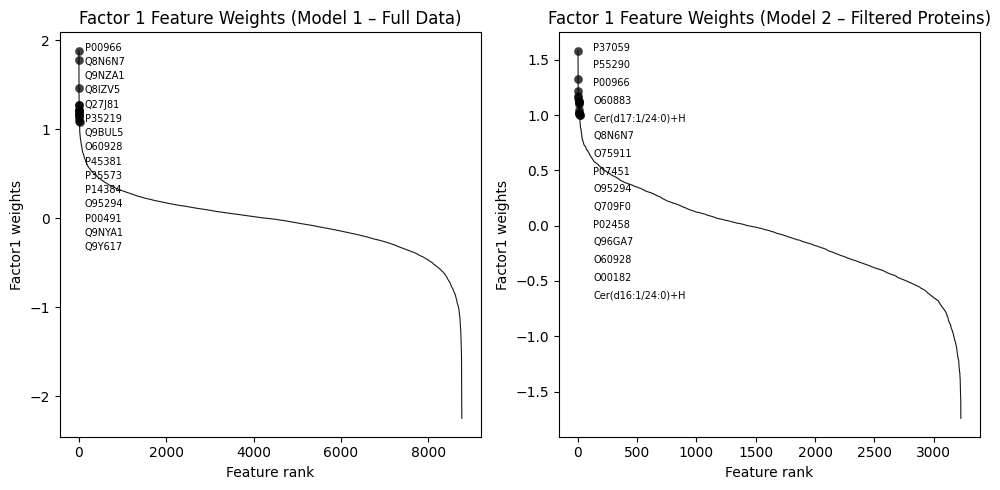

In [18]:
# Plot weights ranked cross-omics to inspect whether less dominant view(s) now contribute more meaningfully
""" 
Code adapted from the function .plot_weights_ranked() from the mofax package. Since the original function only plot ranked weights per view,
we have to manually create a new code to inspect this. 
Source: https://github.com/bioFAM/mofax/blob/master/mofax/plot_weights.py#L295C21-L302C1
"""

# Extract weights and Rank them according to their values. The higher the values, the stronger the correlation.
w1 = m1.get_weights(df=True)["Factor1"].copy()
w1 = w1.sort_values(ascending=False)
df1 = w1.reset_index()
df1.columns = ["feature", "value"]
df1["rank"] = range(1, len(df1)+1)

w2 = m2.get_weights(df=True)["Factor1"].copy()
w2 = w2.sort_values(ascending=False)
df2 = w2.reset_index()
df2.columns = ["feature", "value"]
df2["rank"] = range(1, len(df2)+1)

# Plot side-by-side ranked weights for each model
fig, axes = plt.subplots(1, 2, figsize=(10,5))

# Plot for Model 1 Full Data
axes[0].plot(df1["rank"], df1["value"], linewidth=0.8, alpha=0.9, color='black')
top_df1 = df1.head(15)
axes[0].scatter(
    top_df1["rank"],
    top_df1["value"],
    zorder=3,
    linewidth=0.2,
    alpha=0.75,
    color='black'
    
)

x_label_pos1 = 130
y_start1 = top_df1.iloc[0]["value"]

for i, (_, row) in enumerate(top_df1.iterrows()):
    axes[0].text(
        x_label_pos1,
        y_start1 - i*0.16,
        row["feature"],
        fontsize=7,
        ha="left"
    )

axes[0].set_xlabel("Feature rank")
axes[0].set_ylabel("Factor1 weights")
axes[0].set_title("Factor 1 Feature Weights (Model 1 – Full Data)")

# Plot for Model 2 Filtered Proteins
axes[1].plot(df2["rank"], df2["value"], linewidth=0.8, alpha=0.9, color='black')
top_df2 = df2.head(15)
axes[1].scatter(
    top_df2["rank"],
    top_df2["value"],
    zorder=3,
    linewidth=0.2,
    alpha=0.75,
    color='black'
    
)

x_label_pos2 = 130
y_start2 = top_df2.iloc[0]["value"]

for i, (_, row) in enumerate(top_df2.iterrows()):
    axes[1].text(
        x_label_pos2,
        y_start2 - i*0.16,
        row["feature"],
        fontsize=7,
        ha="left"
    )

axes[1].set_xlabel("Feature rank")
axes[1].set_ylabel("Factor1 weights")
axes[1].set_title("Factor 1 Feature Weights (Model 2 – Filtered Proteins)")

fig.tight_layout()
fig.show()
fig.savefig(output_dir / 'Factor1_Global_Weights_Ranked')

## Phase 3 — Downstream Analysis

1. PCA plots for Factor 1 and 2 based on group labels (Macula vs. Periphery)
2. Top feature rankings per factor 1 and 2
3. GSEA / pathway enrichment (export gene/feature lists, run GSEA, save results)

In [20]:
# PCA plots for Factor 1 and 2 based on group labels (Macula vs. Periphery)
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def confidence_ellipse(x, y, ax, n_std=2.4477, facecolor='none', edgecolor='black', linestyle='--', **kwargs):
    """
    Create a confidence ellipse for a 2D dataset
    n_std=2.4477 corresponds to ~95% confidence for 2D
    """
    if len(x) < 3:
        return None
    
    cov = np.cov(x, y)
    mean_x, mean_y = np.mean(x), np.mean(y)
    
    # Calculate eigenvalues and eigenvectors
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]
    
    # Calculate angle and width/height
    angle = np.degrees(np.arctan2(*eigvecs[:, 0][::-1]))
    width, height = 2 * n_std * np.sqrt(eigvals)
    
    # Create ellipse
    ellipse = Ellipse(
        (mean_x, mean_y),
        width=width,
        height=height,
        angle=angle,
        facecolor=facecolor,
        edgecolor=edgecolor,
        linestyle=linestyle,
        linewidth=2,
        **kwargs
    )
    
    return ax.add_patch(ellipse)

def plot_mofa_factors_with_ellipses(
    model,
    labels: np.ndarray,
    run_name: str = "MOFA+ Factors",
    factor1: str = "Factor1",
    factor2: str = "Factor2",
    save_path: str = None,
    figsize: tuple = (10, 8)
):
    """
    Plot MOFA+ factors with 95% confidence ellipses using matplotlib
    
    Parameters:
    -----------
    model : hdf5 files
        Saved MOFA+ .hdf5 model
    labels : np.ndarray
        Sample class labels
    run_name : str
        Name for the plot title
    factor1 : str
        Name of first factor (e.g., 'Factor1')
    factor2 : str
        Name of second factor (e.g., 'Factor2')
    save_path : str
        Path to save the plot (optional)
    figsize : tuple
        Figure size (width, height)
    """

    # Get factors as DataFrame
    factors_df = model.get_factors(df=True)
    factors_df['label'] = labels
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)
    
    # Get unique groups and colors
    unique_groups = factors_df['label'].unique()
    colors = sns.color_palette("husl", len(unique_groups))
    color_map = dict(zip(unique_groups, colors))
    
    # Plot scatter points for each group
    for group in unique_groups:
        group_data = factors_df[factors_df['label'] == group]
        ax.scatter(
            group_data[factor1],
            group_data[factor2],
            c=[color_map[group]],
            label=group,
            s=100,
            alpha=0.7,
            edgecolors='black',
            linewidth=0.5
        )
        
        # Add confidence ellipse
        if len(group_data) >= 3:
            confidence_ellipse(
                group_data[factor1].values,
                group_data[factor2].values,
                ax,
                edgecolor=color_map[group],
                linestyle='--',
                alpha=0.5
            )
    
    # Labels and title
    sample_names = factors_df.index.tolist()
    display_names = [f"S{name}" for name in sample_names]
    for i, display_name in enumerate(display_names):
        ax.annotate(
            display_name,
            (factors_df[factor1].iloc[i], factors_df[factor2].iloc[i]),
            xytext=(3, 3),
            textcoords='offset points',
            ha='left'
        )
    ax.set_xlabel(factor1, fontsize=12, fontweight='bold')
    ax.set_ylabel(factor2, fontsize=12, fontweight='bold')
    ax.set_title(f'{run_name}: {factor1} vs {factor2}\nwith 95% Confidence Ellipses', 
                 fontsize=14, fontweight='bold')
    
    # Legend
    ax.legend(loc='best', frameon=True, shadow=True)
    
    # Grid
    ax.grid(True, alpha=0.3, linestyle='--')
    
    # Tight layout
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {save_path}")
    
    plt.show()
    
    return factors_df

Plot saved to plots/downstream_analysis/run1_factors_F1_F2.png


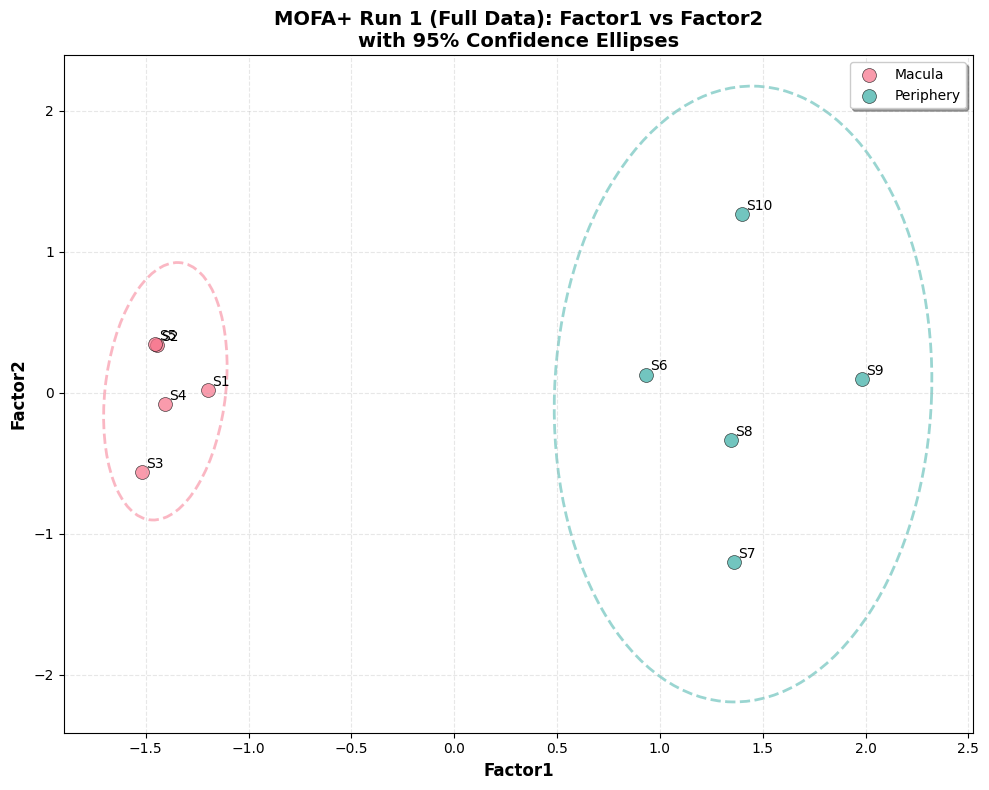

,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,label
1,-1.197157,0.016756,0.369722,0.247292,-0.253947,-0.298418,-0.076167,Macula
2,-1.445803,0.334861,-0.248271,-0.026433,0.017104,0.144481,-0.094971,Macula
3,-1.517738,-0.564753,-0.076134,-0.128548,0.123315,-0.070965,0.111753,Macula
4,-1.404968,-0.082729,-0.024181,0.069406,0.127136,0.013374,0.138004,Macula
5,-1.455927,0.344739,-0.243043,-0.022494,0.017647,0.139560,-0.094247,Macula
6,0.931476,0.128586,0.924071,0.157959,-0.196924,0.212047,0.072424,Periphery
7,1.360814,-1.201420,-0.628668,-0.228513,-0.232780,0.039453,-0.024439,Periphery
8,1.346366,-0.338089,0.694605,-0.213767,0.347707,-0.036497,-0.101509,Periphery
9,1.982001,0.096498,-0.606401,0.578999,0.150400,-0.046458,0.013705,Periphery
10,1.400935,1.265550,-0.161699,-0.433901,-0.099657,-0.096576,0.055447,Periphery


In [24]:
# Plot Factor 1 vs Factor 2 and Display factors values for Run 1 
plot_mofa_factors_with_ellipses(
    model=m1,
    labels=train1.labels,
    run_name="MOFA+ Run 1 (Full Data)",
    factor1='Factor1',
    factor2='Factor2',
    save_path=str(output_dir / 'run1_factors_F1_F2.png')
)

Plot saved to plots/downstream_analysis/run2_factors_F1_F2.png


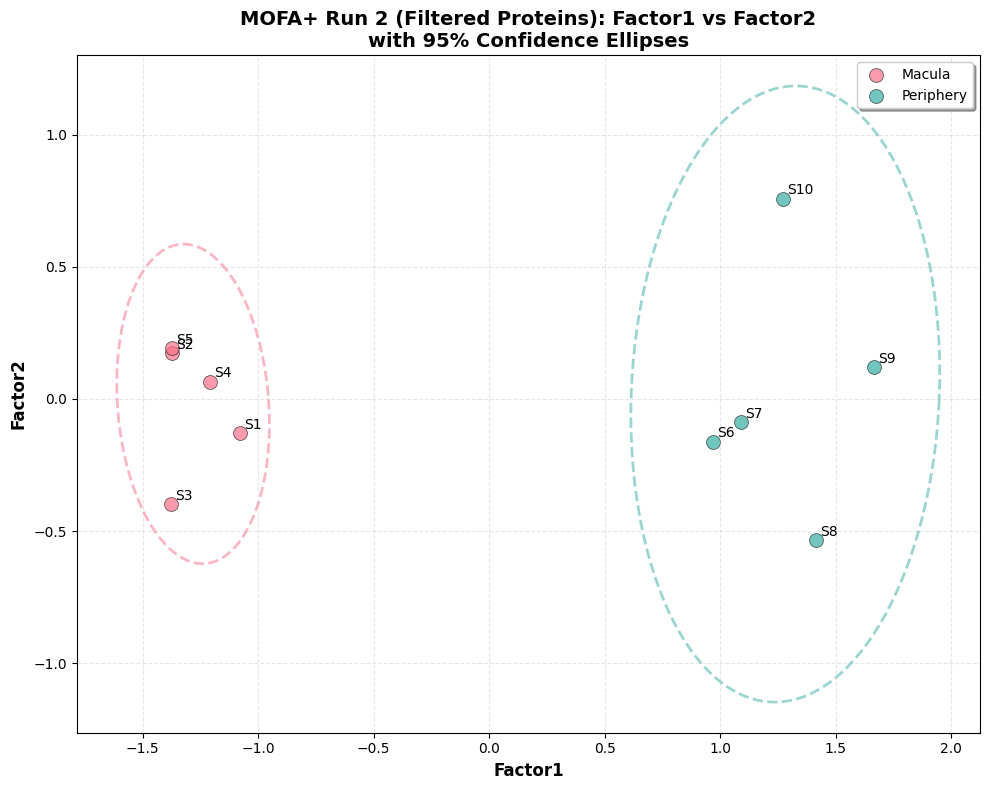

,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,label
1,-1.077787,-0.129368,-0.404317,-0.231847,-0.432679,-0.153355,-0.167907,Macula
2,-1.372701,0.173780,0.058170,-0.014311,0.108054,0.216174,-0.028514,Macula
3,-1.378005,-0.396491,0.226310,0.284470,0.146104,-0.174258,-0.014059,Macula
4,-1.207094,0.065982,0.052154,-0.125802,0.128501,-0.165166,0.193918,Macula
5,-1.371783,0.192949,0.040892,-0.033558,0.099419,0.217132,-0.027251,Macula
6,0.967610,-0.161562,-0.651601,-0.263837,-0.289210,0.107290,0.183385,Periphery
7,1.091455,-0.087796,1.269815,0.098685,-0.265314,0.033040,0.030991,Periphery
8,1.412441,-0.534727,-0.330670,0.390784,0.200060,0.088343,-0.041985,Periphery
9,1.664080,0.119031,0.136019,-0.643972,0.339930,-0.106236,-0.103373,Periphery
10,1.271783,0.758201,-0.396773,0.539388,-0.034865,-0.062963,-0.025205,Periphery


In [26]:
# Plot Factor 1 vs Factor 2 and Display factors values for Run 2
plot_mofa_factors_with_ellipses(
    model=m2,
    labels=train2.labels,
    run_name="MOFA+ Run 2 (Filtered Proteins)",
    factor1='Factor1',
    factor2='Factor2',
    save_path=str(output_dir / 'run2_factors_F1_F2.png')
)